# Compilation time : a comparison

This is a set of functions that perform a comparison of computation time between NumPy, Jax and SPM's sophisticated inference agents in the "maze X" environment (soft maze, large number of hidden states).

Important things to note : 
- The results **will** be different depending on the hardware. In particular, this will depend on the CPU used for the notebook computations and the Matlab script (that is run separately!). The figures obtained here were obtained using an i5-11400H 2.70GHz. 
- You can run Jax functions on GPUs or TPUs. This was not done here.This may however result in significant improvements when computating over tensors of large sizes !
- The computation performed by the Jax implementation and the numpy/matlab implementations are **not the same** ! Out jax sophisticated inference algorithm uses a **fixed size tree** which always explores a subset of the potential actions & states for each new exploration node, thus performing a more complete (but also more expensive) search.



### Notes on Jax processing : 

- **CPUs** : A [nice introduction](https://bnikolic.co.uk/blog/python/jax/2023/03/22/jax-multithreaded.html) on how does Jax CPU multithreading work
- **Multi-process** : The [official documentation](https://jax.readthedocs.io/en/latest/multi_process.html) on distributed computations (that may be useful if you want to parrallelize your synthetic subject pool !)

In [ ]:
# First, let's import stuff !
# Python "classics": 
import os
import numpy as np
import matplotlib.pyplot as plt
import pickle # saving shenanigans
from functools import partial

# Import the necessary jax libraries : 
import jax
import jax.numpy as jnp
import jax.random as jr
from jax import vmap,jit

# We want to measure execution times ! 
import timeit

# Active Inference based packages :
import actynf # import active-pynference package
print("Imported active-pynference - version " + actynf.__version__)

# The usual components of our sophisticated inference implementation : 
from actynf import layer,link
from actynf import layer_network as network

# The jax functions that allow us to run jax sophisticated inference training simulations
# Not yet incorporated into the generic layer class :(
from actynf.jaxtynf.layer_options import get_planning_options,get_action_selection_options,get_learning_options
from actynf.jaxtynf.layer_training import synthetic_training





# The weights for the maze :
from local_demo_tools.mazex.weights import build_maze,build_maze_model
# Plotting functions for prettiness :D
from local_demo_tools.mazex.plot import mazeplot

# This is the maze we're working with !
MAZE_ARRAY = np.array([
    [1,1,1,1,1,1,1,1],
    [1,0,0,0,0,0,0,1],
    [1,1,1,0,1,1,0,1],
    [1,1,0,0,0,1,0,1],
    [1,1,0,1,0,0,0,1],
    [1,1,0,1,1,1,0,1],
    [1,0,0,0,0,0,0,1],
    [1,0,1,1,1,1,1,1]
])
START_IDX = (7,1)
END_IDX = (4,4)

COMPUTE_TIMES_SAVEPATH = os.path.join(".","local_resources","mazex","compute_times")
FIGURES_SAVEPATH = os.path.join(".","local_resources","mazex","renders")

Imported active-pynference - version 0.1.39


c:\Users\annic\OneDrive\Bureau\MainPhD\code\venvs\jax_new\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


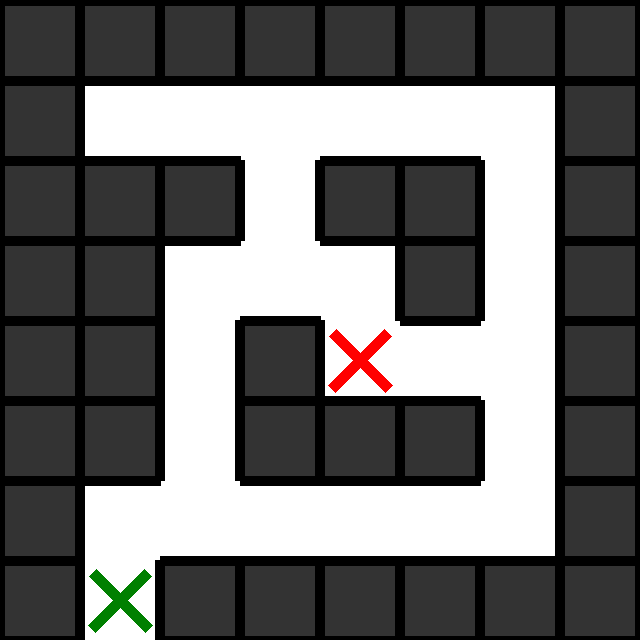

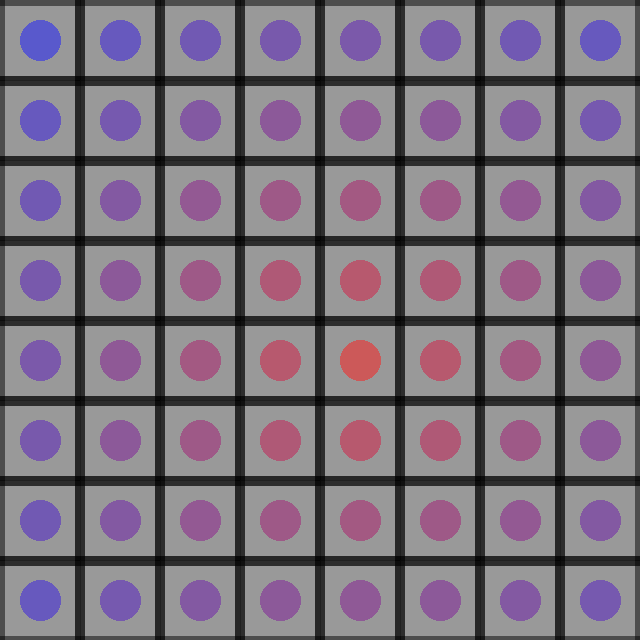

In [2]:
# Show the (true) environment explored by the subject
maze_img = mazeplot(MAZE_ARRAY,START_IDX,END_IDX)
display(maze_img)

# The model entertained by the subject :
dirac_goal = False
a_show,_,c_show,_,_,_ = build_maze_model(MAZE_ARRAY,START_IDX,END_IDX,
                               initial_tile_confidence=1.0,dirac_goal=dirac_goal)

# Initial belief about the maze :
maze_model_img = mazeplot(MAZE_ARRAY,START_IDX,END_IDX,0,a=a_show,c=c_show,show_start_and_stop=False)
display(maze_model_img)

We are interested in the run time for simulations following 3 parameters : the amount of subjects we will simulate (an obvious Jax strong point), the amount of trial simulated, and the complexity of the tree planning (i.e. how many branches are computed during planning). This is guided by the subject representation of the maze. We thus introduce (artificial) uncertainty regarding state transitions to manually reduce the amount of tree pruning performed during sophisticated planning.
- **Parameter 1 :** $N_{subj}$, will take values [10,50,100,500,1000,10000]
- **Parameter 2 :** $N_{trials}$ will take values [20,50,100]
- **Parameter 3 :** $p_{transition}$ describes the probability of actually moving to the expected cell given a specific action. It will take values [1.0,0.5], with $p_{transition}=0.5$ creating 2 additionnal state branches during planning (significantly increasing the complexity of the sophisticated planning).

In [5]:
def tensorify(*args):
    """ A very ugly function that transforms numpy arrays into jax tensors, while conserving list structures."""
    all_results = []
    for arg in args :
        if type(arg)==list :
            # We return a list of tensorified args :
            return_list = []
            for el in arg :
                return_list.append(tensorify(el))
            all_results.append(return_list)
        else :
            all_results.append(jnp.array(arg))
    
    if len(all_results)==1:
        return all_results[0]
    else :
        return tuple(all_results)

def check_save_exists(candidate,savepath):
    check_attributes = ["p_transition","Th","N_subjs","N_trials","sample_size","method"] # No lists or classes !
    with open(savepath, 'rb') as handle:
        list_of_saves = pickle.load(handle)
        assert type(list_of_saves), "This file should be a list..."
        for existing_save in list_of_saves:
            same_specs = [candidate[attr]==existing_save[attr] for attr in check_attributes]
            if all(same_specs):
                return True,existing_save
    return False,None


def jax_si_timewrapper(A,B,C,D,E,U,a,b,c,d,e,T,Th,
                 Nsubj,Ntrials):
    """ 
    Build a jax sophisticated inference network and run it. Also provide the running time !
    Warning : measuring execution times in jax is a bit trickier than in regular numpy due to 
    the asynchronous execution. We use block_until_ready() to ensure all results are computed !
    We also jit the function and run it once to precompile it.
    """
    # Training options :
    Sh = 1                      # State horizon (or the number of inidividual states that will create their own branch)
    remainder_state_bool = True # Do we create an additional branch with the remaining potential state density ?
    Ph = 5                      # Policy horizon (or the number of individual actions that will be explored at each node)
    option_a_nov = False
    option_b_nov = False
    additional_options_planning = False    

    planning_options = get_planning_options(Th,"classic",#"sophisticated",
                            Sh,Ph,remainder_state_bool,
                            option_a_nov,option_b_nov,additional_options_planning)

    as_options = get_action_selection_options("stochastic",alpha=16)

    learn_a,learn_b,learn_d = True,False,True
    learn_options = get_learning_options(learn_a,learn_b,learn_d,run_smoother=True)

    training_parrallel_func = partial(synthetic_training,
        Ntrials=Ntrials,T=T,
        A=A,B=B,D=D,U=U,
        a0=a,b0=b,c=c,d0=d,e=e,
        planning_options=planning_options,
        action_selection_options = as_options,
        learning_options = learn_options)
    jitted_training = jit(training_parrallel_func)
    
    compil_start = timeit.default_timer()
    rngkey_prime = jr.PRNGKey(0)
    res = jitted_training(rngkey_prime)
    res[0][0].block_until_ready()
    compil_end = timeit.default_timer()
    
    compiltime = compil_end-compil_start
    print(f"compilation took {compiltime:.3f} s")
    
    total = 0
    all_keys = jr.split(jr.PRNGKey(np.random.randint(0,100)),Nsubj)
    for subj in range(Nsubj):
        parrallel_start = timeit.default_timer()
        
        res_multiple = jitted_training(all_keys[subj])
        res_multiple[0][0].block_until_ready()
        parrallel_end = timeit.default_timer()
        
        runtime = parrallel_end-parrallel_start
        print(f"running subject {subj:02} took {runtime:.3f} s")
        total = total + runtime
    print(total)
    return [compiltime,runtime],res_multiple
    

def numpy_si_timewrapper(A,B,C,D,E,U,a,b,c,d,e,T,Th,
                 Nsubj,Ntrials):
    """ Build a numpy sophisticated inference network and run it. Also provide the running time !"""
    
    # Setting up the network, we ignore this
    seed = np.random.randint(0,9999)
    maze_process = layer("maze_environment","process",A,B,C,D,E,U,T,Th,in_seed=seed)
    seed = np.random.randint(0,9999)
    maze_model = layer("maze_model","model",
                a,b,c,d,e,U,T,Th,in_seed=seed)
    maze_model.learn_options.learn_a = True
    maze_model.learn_options.learn_b = False
    maze_model.learn_options.learn_d = True
    maze_model.hyperparams.alpha = 16
    maze_model.hyperparams.a_novelty = True


    maze_process.inputs.u = link(maze_model,lambda x : x.u)
    maze_model.inputs.o = link(maze_process,lambda x : x.o)

    maze_net = network([maze_process,maze_model],"maze")
    
    
    rez = {"stms":[],"weights":[]}
    
    # Start measuring time now !
    start = timeit.default_timer()
    
    
    for sub in range(Nsubj):
        subj_net = maze_net.copy_network(sub)

        STMs,weights = subj_net.run_N_trials(Ntrials,return_STMs=True,return_weights=True)
        rez["stms"].append(STMs)
        rez["weights"].append(weights)
        
    stop = timeit.default_timer()
    
    return stop-start,rez

def testing_bench(path,p_transition,N_subjs,N_trials,Th,method="numpy",sample_size = 10,override= False):
    """ I am a timing comparator :D """
    # Ensure the folders + file we save all results to exists (should only be triggered once)
    if not os.path.exists(os.path.dirname(path)):
        os.makedirs(os.path.dirname(path))
    
    if not os.path.isfile(path):
        emptylist = []
        with open(path, 'wb') as handle:
            pickle.dump(emptylist, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
    # This is the set of parameters we're testing
    save_container = {
        "p_transition":p_transition,
        "Th": Th,
        "N_subjs" : N_subjs,
        "N_trials" : N_trials,
        "sample_size" : sample_size,
        "method" : method,
        "delta_t" : []
    }
    
    # Check if it already exists
    already_exists,existing_container_if_exists = check_save_exists(save_container,path)
    if already_exists and (not(override)):
        print("Already recorded performances, bypassing ... If you want to record again, enable override !")
        return existing_container_if_exists
    
    
    # Set up the model
    T = 10
    
    # The traditional Active Inference 
    # HMM associated with the maze below !
    A,B,C,D,E,U = build_maze(MAZE_ARRAY,START_IDX,END_IDX)  
    
    # The model entertained by the subject :
    dirac_goal = False
    a,b,c,d,e,u = build_maze_model(MAZE_ARRAY,START_IDX,END_IDX,
                                initial_tile_confidence=1.0,dirac_goal=dirac_goal,p_transition=p_transition)
    
    if method=="numpy":
        for sample in range(sample_size):
            deltat_t, results = numpy_si_timewrapper(A,B,C,D,E,U,a,b,c,d,e,T,Th,N_subjs,N_trials)
            save_container["delta_t"].append(deltat_t)
    elif method =="jax":
        A,B,C,D,E,U = tensorify(A,B,C,D,E,U)
        a,b,c,d,e,u = tensorify(a,b,c,d,e,u)
        U = jnp.expand_dims(U,axis=-1)
        print(U)
        for sample in range(sample_size):
            print(sample)
            deltat_t, results = jax_si_timewrapper(A,B,C,D,E,U,a,b,c,d,e,T,Th,N_subjs,N_trials)
            save_container["delta_t"].append(deltat_t)
    elif method =="matlab":
        save_container["delta_t"].append(0)
        print("We don't run Matlab script from here :( \n TODO : load results generated using the SPM package here")
        raise NotImplementedError("Loading pipeline todo")
    else : 
        raise NotImplementedError("This sophisticated planning implementation has not been implemented")
    
    
    # Save the container : 
    with open(path, 'rb') as handle:
        list_of_existing_containers = pickle.load(handle)
        
    list_of_existing_containers.append(save_container)
    
    with open(path, 'wb') as handle:
        pickle.dump(list_of_existing_containers, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
    print("Saved timing results to :   " + path)
    return save_container

save_to_this_folder = os.path.join(COMPUTE_TIMES_SAVEPATH,"saved_chronos")
N = 10
Th = 5
Nsub = 10
p_transition = 1.0
Ntrials = 100
print(testing_bench(save_to_this_folder,p_transition,Nsub,Ntrials,Th,'jax',N,override=True))


[[0]
 [1]
 [2]
 [3]
 [4]]
0
compilation took 10.208 s
running subject 00 took 7.441 s
running subject 01 took 7.429 s
running subject 02 took 7.450 s
running subject 03 took 7.418 s
running subject 04 took 7.436 s
running subject 05 took 7.424 s
running subject 06 took 7.490 s
running subject 07 took 7.442 s
running subject 08 took 7.440 s
running subject 09 took 7.449 s
74.41831970000203
1
compilation took 9.931 s
running subject 00 took 7.475 s
running subject 01 took 7.483 s
running subject 02 took 7.451 s
running subject 03 took 7.541 s
running subject 04 took 7.524 s
running subject 05 took 7.441 s
running subject 06 took 7.506 s
running subject 07 took 7.490 s
running subject 08 took 7.473 s
running subject 09 took 7.457 s
74.84043519999977
2
compilation took 10.027 s
running subject 00 took 7.484 s
running subject 01 took 7.455 s
running subject 02 took 7.466 s
running subject 03 took 7.475 s
running subject 04 took 7.445 s
running subject 05 took 7.482 s
running subject 06 took